# Ackerman and Marley Cloud Model

Here, we try to compute a cloud opacity using Ackerman and Marley Model.
We consider enstatite (MgSiO3) and Fe clouds.  


In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

Setting a simple atmopheric model. We need the density of atmosphere.

In [2]:
from exojax.utils.constants import kB, m_u
from exojax.atm.atmprof import pressure_layer_logspace

Parr, dParr, k = pressure_layer_logspace(log_pressure_top=-4., log_pressure_btm=6.0, nlayer=100)
alpha = 0.097
T0 = 1200.
Tarr = T0 * (Parr)**alpha

mu = 2.0  # mean molecular weight
R = kB / (mu * m_u)
rho = Parr / (R * Tarr)


The solar abundance can be obtained using utils.zsol.nsol. Here, we assume a maximum mol Mixing Ratio for MgSiO3 and Fe from solar abundance. 

In [3]:
from exojax.utils.zsol import nsol

n = nsol()  #solar abundance
MolMR_enstatite = np.min([n["Mg"], n["Si"], n["O"] / 3])
MolMR_Fe = n["Fe"]


Vapor saturation pressures can be obtained using atm.psat

In [4]:
from exojax.atm.psat import psat_enstatite_AM01, psat_Fe_AM01, _psat_Fe_solid

P_enstatite = psat_enstatite_AM01(Tarr)
#P_fe_sol = psat_Fe_AM01(Tarr)
P_fe_sol = _psat_Fe_solid(Tarr)


Compute a cloud base pressure.

In [5]:
from exojax.atm.amclouds import compute_cloud_base_pressure

Pbase_enstatite = compute_cloud_base_pressure(Parr, P_enstatite, MolMR_enstatite)
Pbase_Fe_sol = compute_cloud_base_pressure(Parr, P_fe_sol, MolMR_Fe)


The cloud base is located at the intersection of a TP profile and the vapor saturation puressure devided by VMR.

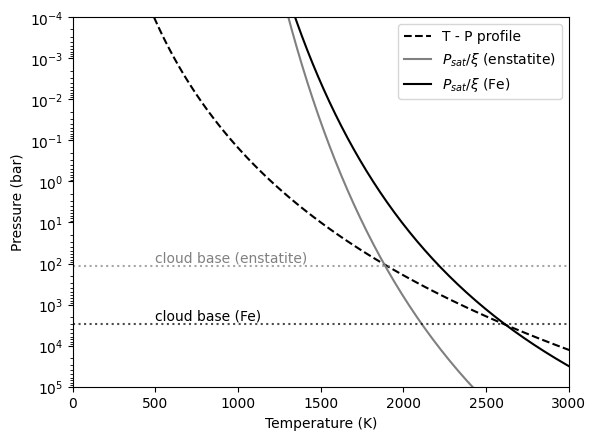

In [6]:
plt.plot(Tarr, Parr, color="black", ls="dashed", label="T - P profile")
plt.plot(Tarr,
         P_enstatite / MolMR_enstatite,
         label="$P_{sat}/\\xi$ (enstatite)",
         color="gray")
plt.axhline(Pbase_enstatite, color="gray", alpha=0.7, ls="dotted")
plt.text(500, Pbase_enstatite * 0.8, "cloud base (enstatite)", color="gray")

plt.plot(Tarr, P_fe_sol / MolMR_Fe, label="$P_{sat}/\\xi$ (Fe)", color="black")
plt.axhline(Pbase_Fe_sol, color="black", alpha=0.7, ls="dotted")
plt.text(500, Pbase_Fe_sol * 0.8, "cloud base (Fe)", color="black")

plt.yscale("log")
plt.ylim(1.e-4, 1.e5)
plt.xlim(0, 3000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.savefig("pbase.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("pbase.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

Compute VMRs of clouds. Because Parr is an array, we apply jax.vmap to atm.amclouds.VMRclouds.

In [7]:
from exojax.atm.amclouds import mixing_ratio_cloud_profile
from exojax.spec.molinfo import molmass_isotope
from exojax.atm.mixratio import vmr2mmr
fsed = 3.
muc_enstatite = molmass_isotope("MgSiO3")
MMRbase_enstatite = vmr2mmr(muc_enstatite,mu,MolMR_enstatite)
MMRc_enstatite = mixing_ratio_cloud_profile(Parr, Pbase_enstatite, fsed, MMRbase_enstatite)

muc_Fe = molmass_isotope("Fe")
MMRbase_Fe = vmr2mmr(muc_Fe,mu,MolMR_Fe)
MMRc_Fe = mixing_ratio_cloud_profile(Parr, Pbase_Fe_sol, fsed, MMRbase_Fe)



['H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 'NH3', 'HNO3', 'OH', 'HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2', 'C2H2', 'C2H6', 'PH3', 'COF2', 'SF6', 'H2S', 'HCOOH', 'HO2', 'O', 'ClONO2', 'NO+', 'HOBr', 'C2H4', 'CH3OH', 'CH3Br', 'CH3CN', 'CF4', 'C4H2', 'HC3N', 'H2', 'CS', 'SO3', 'C2N2', 'COCl2', 'SO', 'CH3F', 'GeH4', 'CS2', 'CH3I', 'NF3']
['H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 'NH3', 'HNO3', 'OH', 'HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2', 'C2H2', 'C2H6', 'PH3', 'COF2', 'SF6', 'H2S', 'HCOOH', 'HO2', 'O', 'ClONO2', 'NO+', 'HOBr', 'C2H4', 'CH3OH', 'CH3Br', 'CH3CN', 'CF4', 'C4H2', 'HC3N', 'H2', 'CS', 'SO3', 'C2N2', 'COCl2', 'SO', 'CH3F', 'GeH4', 'CS2', 'CH3I', 'NF3']


/home/kawahara/exojax/src/exojax/spec/molinfo.py:64: UserWarning: db_HIT is set as True, but the molecular name 'MgSiO3' does not exist in the HITRAN database. So set db_HIT as False. For reference, all the available molecules in the HITRAN database are as follows:
  warnings.warn(warn_msg, UserWarning)
/home/kawahara/exojax/src/exojax/spec/molinfo.py:64: UserWarning: db_HIT is set as True, but the molecular name 'Fe' does not exist in the HITRAN database. So set db_HIT as False. For reference, all the available molecules in the HITRAN database are as follows:
  warnings.warn(warn_msg, UserWarning)


In [8]:
print(Pbase_enstatite, Pbase_Fe_sol)


114.975746 2983.6467


Here is the MMR distribution.

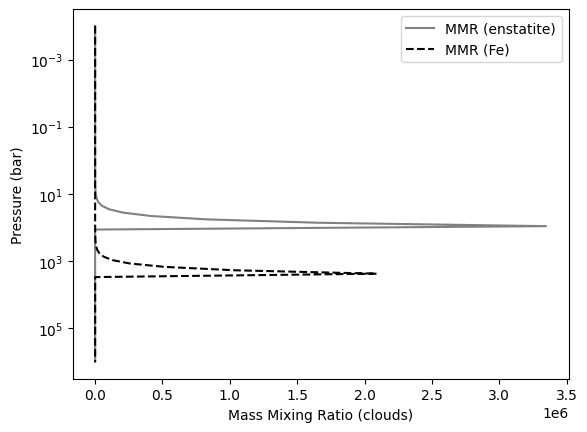

In [9]:
plt.figure()
plt.gca().get_xaxis().get_major_formatter().set_powerlimits([-3, 3])
plt.plot(MMRc_enstatite, Parr, color="gray", label="MMR (enstatite)")
plt.plot(MMRc_Fe, Parr, color="black", ls="dashed", label="MMR (Fe)")

plt.yscale("log")
#plt.ylim(1.e-7, 10000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Mass Mixing Ratio (clouds)")
plt.ylabel("Pressure (bar)")
plt.savefig("mmrcloud.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("mmrcloud.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

Compute dynamic viscosity in H2 atmosphere (cm/g/s)

In [10]:
from exojax.atm.viscosity import eta_Rosner, calc_vfactor

T = np.logspace(np.log10(1000), np.log10(2000))
vfactor, Tr = calc_vfactor("H2")
eta = eta_Rosner(T, vfactor)


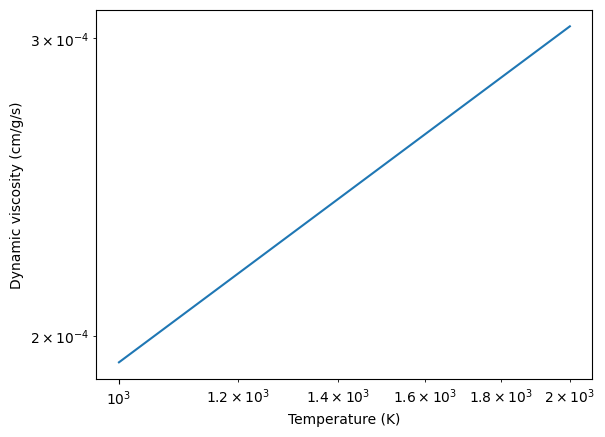

In [11]:
plt.plot(T, eta)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature (K)")
plt.ylabel("Dynamic viscosity (cm/g/s)")
plt.show()

The pressure scale height can be computed using atm.atmprof.Hatm.

In [12]:
from exojax.atm.atmprof import pressure_scale_height
T = 1000  #K
print("scale height=", pressure_scale_height(1.e5, T, mu), "cm")


scale height= 415722.99317937146 cm


We need the substance density of condensates. 

In [13]:
from exojax.atm.condensate import condensate_substance_density, name2formula

deltac_enstatite = condensate_substance_density[name2formula["enstatite"]]
deltac_Fe = condensate_substance_density["Fe"]


Let's compute the terminal velocity. 
We can compute the terminal velocity of cloud particle using atm.vterm.vf.
vmap is again applied to vf.

In [14]:
from exojax.atm.viscosity import calc_vfactor, eta_Rosner
from exojax.atm.vterm import terminal_velocity
from jax import vmap

vfactor, trange = calc_vfactor(atm="H2")
rarr = jnp.logspace(-6, -4, 2000)  #cm
drho = deltac_enstatite - rho
eta_fid = eta_Rosner(Tarr, vfactor)

g = 1.e5
vf_vmap = vmap(terminal_velocity, (None, None, 0, 0, 0))
vfs = vf_vmap(rarr, g, eta_fid, drho, rho)


Kzz/L will be used to calibrate $r_w$. following Ackerman and Marley 2001  

In [15]:
Kzz = 1.e5  #cm2/s
sigmag = 2.0
alphav = 1.3
L = pressure_scale_height(g, 1500, mu)


In [16]:
Kzz/L

0.16036319318499204

Text(0.5, 0, 'condensate size (cm)')

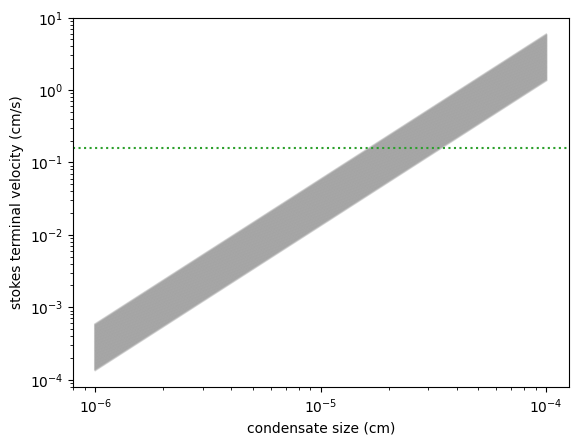

In [17]:
for i in range(0, len(Tarr)):
    plt.plot(rarr, vfs[i, :], alpha=0.2, color="gray")
plt.xscale("log")
plt.yscale("log")
plt.axhline(Kzz / L, label="Kzz/H", color="C2", ls="dotted")
plt.ylabel("stokes terminal velocity (cm/s)")
plt.xlabel("condensate size (cm)")

Find the intersection.

In [18]:
from exojax.atm.amclouds import find_rw

vfind_rw = vmap(find_rw, (None, 0, None), 0)
rw = vfind_rw(rarr, vfs, Kzz / L)


Then, $r_g$ can be computed from $r_w$ and other quantities.

In [19]:
from exojax.atm.amclouds import get_rg

rg = get_rg(rw, fsed, alphav, sigmag)


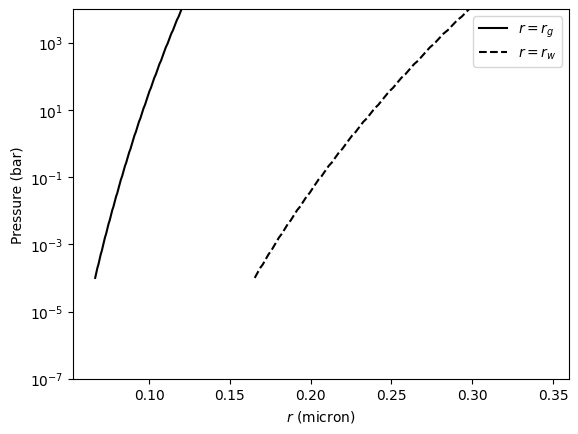

In [20]:
plt.plot(rg * 1.e4, Parr, label="$r=r_g$", color="black")
plt.plot(rw * 1.e4, Parr, ls="dashed", label="$r=r_w$", color="black")
plt.ylim(1.e-7, 10000)
plt.xlabel("$r$ (micron)")
plt.ylabel("Pressure (bar)")
plt.yscale("log")
plt.savefig("rgrw.png")
plt.legend()

We found here the particle size is basically sub-micron. So, we should use the Rayleigh scattering. 
But, here, we try to use the geometric cross section instead though this is wrong. 

In [21]:
from exojax.atm.amclouds import layer_optical_depth_cloudgeo

dtau_enstatite = layer_optical_depth_cloudgeo(Parr, deltac_enstatite, MMRc_enstatite, rg, sigmag, g)
dtau_Fe = layer_optical_depth_cloudgeo(Parr, deltac_Fe, MMRc_Fe, rg, sigmag, g)


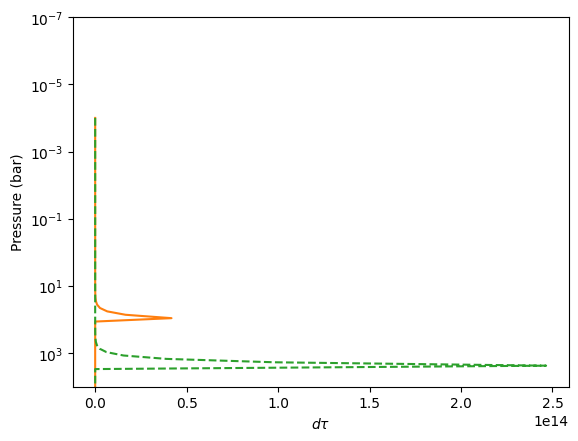

In [22]:
plt.plot(dtau_enstatite, Parr, color="C1")
plt.plot(dtau_Fe, Parr, color="C2", ls="dashed")
plt.yscale("log")
plt.ylim(1.e-7, 10000)
plt.xlabel("$d\\tau$")
plt.ylabel("Pressure (bar)")
#plt.xscale("log")
plt.gca().invert_yaxis()

Let's compare with CIA

In [23]:
#CIA
from exojax.utils.grids import wavenumber_grid

nus, wav, res = wavenumber_grid(9500, 30000, 1000, unit="AA", xsmode="premodit")

from exojax.spec import contdb

cdbH2H2 = contdb.CdbCIA('.database/H2-H2_2011.cia', nus)

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
H2-H2


/home/kawahara/exojax/src/exojax/spec/unitconvert.py:62: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/grids.py:142: UserWarning: Resolution may be too small. R=868.7669794117727
  warnings.warn('Resolution may be too small. R=' + str(resolution),


In [24]:
from exojax.spec.layeropacity import layer_optical_depth_CIA
from exojax.atm.mixratio import mmr2vmr
mmw = 2.33  #mean molecular weight
mmrH2 = 0.74
molmassH2 = molmass_isotope("H2")
vmrH2 = mmr2vmr(mmrH2,mmw, molmassH2) 
dtaucH2H2=layer_optical_depth_CIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


In [25]:
dtau = dtaucH2H2 + dtau_enstatite[:, None] + dtau_Fe[:, None]


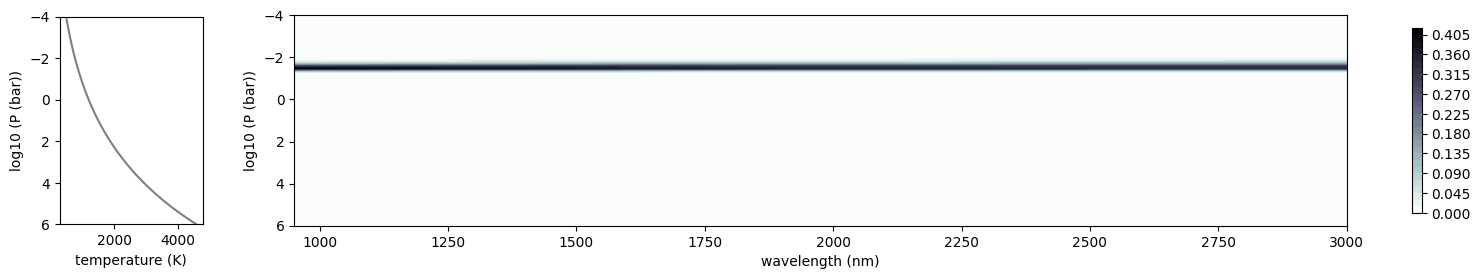

In [26]:
from exojax.plot.atmplot import plotcf

plotcf(nus, dtau, Tarr, Parr, dParr, unit="nm")
plt.show()

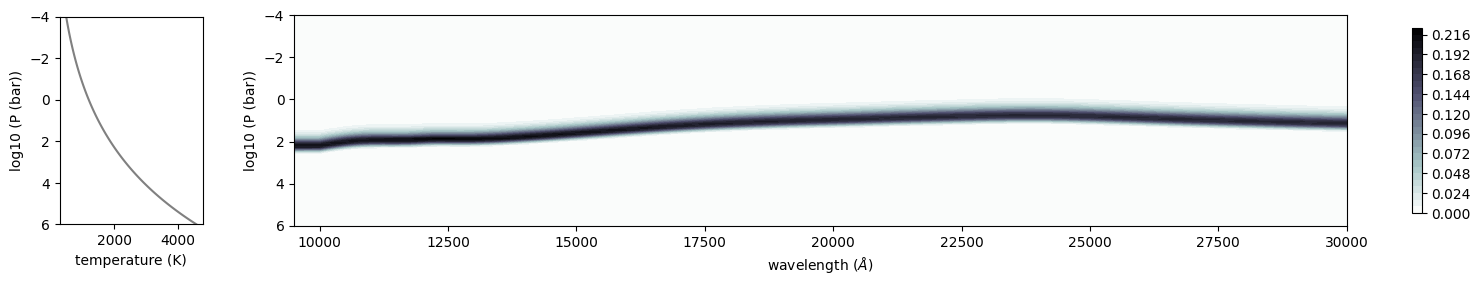

In [27]:
from exojax.plot.atmplot import plotcf

plotcf(nus, dtaucH2H2, Tarr, Parr, dParr, unit="AA")
plt.show()

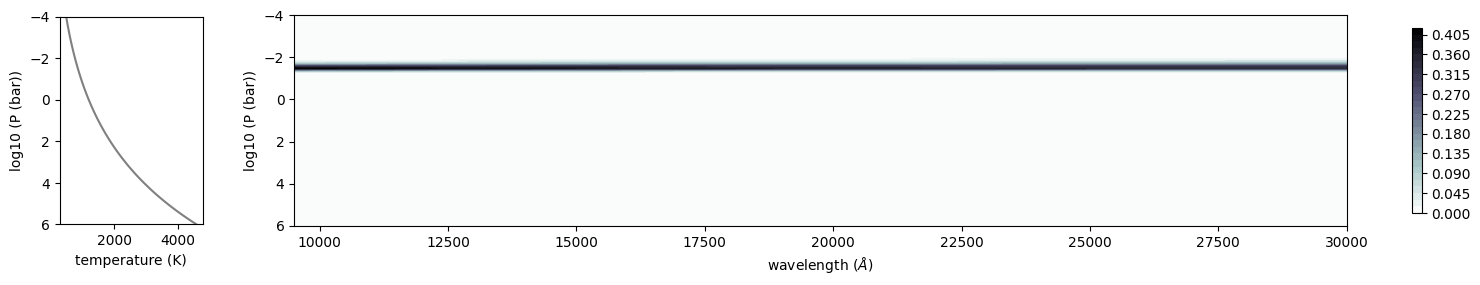

In [28]:
from exojax.plot.atmplot import plotcf

plotcf(nus,
       dtau_enstatite[:, None] + np.zeros_like(dtaucH2H2),
       Tarr,
       Parr,
       dParr,
       unit="AA")
plt.show()

In [29]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun_emis_pureabs_fbased2st as rtrun

sourcef = planck.piBarr(Tarr, nus)
F0 = rtrun(dtau, sourcef)
F0CIA = rtrun(dtaucH2H2, sourcef)
F0cl = rtrun(dtau_enstatite[:, None] + np.zeros_like(dtaucH2H2), sourcef)


In [30]:
from exojax.spec.rtransfer import trans2E3
def _rtrun_emis_pureabs_fbased2st(dtau, source_matrix):
    """Radiative Transfer for emission spectrum using flux-based two-stream pure absorption with no surface
    Args:
        dtau (2D array): optical depth matrix, dtau  (N_layer, N_nus)
        source_matrix (2D array): source matrix (N_layer, N_nus)

    Returns:
        flux in the unit of [erg/cm2/s/cm-1] if using piBarr as a source function.
    """
    Nnus = jnp.shape(dtau)[1]
    TransM = jnp.where(dtau == 0, 1.0, trans2E3(dtau))
    Qv = jnp.vstack([(1 - TransM) * source_matrix, jnp.zeros(Nnus)])
    
    return jnp.nansum(
        Qv * jnp.cumprod(jnp.vstack([jnp.ones(Nnus), TransM]), axis=0), axis=0
    )



In [38]:

F0cl = _rtrun_emis_pureabs_fbased2st(dtau_enstatite[:, None] + np.zeros_like(dtaucH2H2), sourcef)
F0CIA = _rtrun_emis_pureabs_fbased2st(dtaucH2H2, sourcef)
F0 = _rtrun_emis_pureabs_fbased2st(dtau, sourcef)

print(F0cl)

[4.63390332e+03 4.61946826e+03 4.60504688e+03 4.59063721e+03
 4.57623535e+03 4.56184814e+03 4.54747070e+03 4.53310645e+03
 4.51875293e+03 4.50441113e+03 4.49008105e+03 4.47576465e+03
 4.46145752e+03 4.44716553e+03 4.43288574e+03 4.41861865e+03
 4.40436328e+03 4.39012158e+03 4.37589209e+03 4.36167676e+03
 4.34747607e+03 4.33328711e+03 4.31911230e+03 4.30495215e+03
 4.29080469e+03 4.27667188e+03 4.26255371e+03 4.24844922e+03
 4.23435693e+03 4.22028418e+03 4.20622070e+03 4.19217676e+03
 4.17814355e+03 4.16412842e+03 4.15012695e+03 4.13614062e+03
 4.12216895e+03 4.10821582e+03 4.09427441e+03 4.08035132e+03
 4.06644507e+03 4.05255151e+03 4.03867676e+03 4.02481860e+03
 4.01097607e+03 3.99714990e+03 3.98333936e+03 3.96954736e+03
 3.95577148e+03 3.94201245e+03 3.92827002e+03 3.91454541e+03
 3.90083643e+03 3.88714697e+03 3.87347681e+03 3.85982080e+03
 3.84618311e+03 3.83256494e+03 3.81896509e+03 3.80538135e+03
 3.79181689e+03 3.77827197e+03 3.76474414e+03 3.75123535e+03
 3.73774463e+03 3.724273

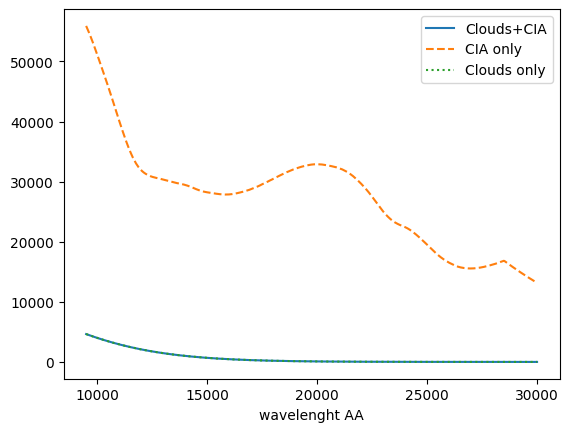

In [39]:
plt.plot(wav[::-1], F0, label="Clouds+CIA")
plt.plot(wav[::-1], F0CIA, label="CIA only", ls="dashed")
plt.plot(wav[::-1], F0cl, label="Clouds only", ls="dotted")
plt.xlabel("wavelenght AA")
plt.legend()
plt.show()